# Classification: Initial tinkering with E. coli iModulon data to see if we can train a CNN to classify promoters into iModulons

In [1]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats


import altair as alt
import seaborn as sns
import torch_utils as tu

import torch

In [2]:
import utils as u 
import torch_utils as tu
import models as m

from sklearn.metrics import r2_score

from skorch import NeuralNetRegressor,NeuralNetClassifier
from skorch.callbacks import EarlyStopping,Checkpoint,GradientNormClipping
from skorch.dataset import Dataset
from skorch.helper import predefined_split


## Load data

In [3]:
fname = 'ec_iMod_out/ecoli_seq_M_opFilt.tsv' 
XY = pd.read_csv(fname,sep='\t')
print(XY.shape)
display(XY.head())

loc2seq = dict([(x,z) for (x,z) in XY[['locus_tag','upstream_region']].values])

print(loc2seq['b3575'])

(2129, 99)


,locus_tag,gene,product,type,strand,start,upstream_region,0,1,2,...,82,83,84,85,86,87,88,89,90,91
0,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...,0.008229,-0.000685,-0.005215,...,-0.006856,0.010676,0.008874,0.018497,0.000700,-0.013267,0.015265,0.016886,-0.015319,-0.020727
1,b0007,yaaJ,putative transporter YaaJ,CDS,-1,6528,AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...,0.008111,-0.003929,0.003207,...,-0.000337,-0.010468,0.016122,0.010361,-0.003899,-0.022839,-0.003665,-0.001823,-0.023604,-0.012765
2,b0008,talB,transaldolase B,CDS,1,8237,ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...,0.008629,-0.001270,-0.005664,...,0.000394,0.007215,-0.000707,-0.012959,-0.002329,0.006391,-0.003650,-0.008537,0.002898,-0.000891
3,b0009,mog,molybdopterin adenylyltransferase,CDS,1,9305,AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...,0.002952,0.002053,-0.002882,...,-0.009291,-0.000226,0.016013,0.002179,0.004891,-0.002365,-0.003490,-0.006066,-0.011982,0.011477
4,b0010,satP,acetate/succinate:H(+) symporter,CDS,-1,9927,CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...,0.006142,0.000884,0.008166,...,-0.009214,-0.010588,0.001363,0.003979,-0.005208,0.003190,-0.015137,-0.005784,-0.001302,0.010800


TCAATCAGCATCAACCCGCGAAACAGACTCTGGCTTCCGGCTGGACGCTCTTTTTCCTGCGCCATCTCGTTCTCTTTTTTTCCCATCACTTCTTTCCCCATTTTGTCGCGTCCTGATGGTAGCGCAAAGTGTGCCGTAGTTCACGATCTCGACAGATAATTTATAACCAATTGATTTTTATGTCTTTTGAAATTCATCAATCAGATTGCCTTGTTAAAAAGTGATCGATATATTTGAAATCAAGTTTCGCATATTGAAATTTTAAGCCAAAAAAGCGATCAAAAAAACAAGGAAGCCTGG


In [4]:
# get iModulon column labels
M = pd.read_csv('ec_iMod_out/iMod_download/M.csv',index_col=0)
imods = [x.strip() for x in M.columns]
imods[:5]

['0', '1', '2', '3', '4']

In [5]:
# load binarized version of M matrix
Mb = pd.read_csv('ec_iMod_out/iMod_download/gene_presence_matrix.csv',index_col=0).astype(int)
Mb.index.name='locus_tag'
Mb

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b0006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b4693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b4696_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Convert XY into binarazed version
XYb = pd.merge(XY.drop(imods,axis=1), Mb.reset_index(),on='locus_tag')
XYb

,locus_tag,gene,product,type,strand,start,upstream_region,0,1,2,...,82,83,84,85,86,87,88,89,90,91
0,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,b0007,yaaJ,putative transporter YaaJ,CDS,-1,6528,AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,b0008,talB,transaldolase B,CDS,1,8237,ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,b0009,mog,molybdopterin adenylyltransferase,CDS,1,9305,AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,b0010,satP,acetate/succinate:H(+) symporter,CDS,-1,9927,CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,b4395,ytjC,putative phosphatase,CDS,1,4633796,TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2125,b4396,rob,DNA-binding transcriptional dual regulator Rob,CDS,-1,4634440,ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2126,b4397,creA,PF05981 family protein CreA,CDS,1,4635520,CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2127,b4401,arcA,DNA-binding transcriptional dual regulator ArcA,CDS,-1,4639589,ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


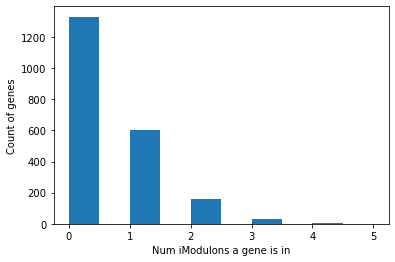

In [12]:
# distribution of ecoli genes and how many iMods they are in
plt.hist([sum(XYb.iloc[i][imods]) for i in range(XYb.shape[0])])
plt.xlabel("Num iModulons a gene is in")
plt.ylabel("Count of genes")
plt.show()

## Filter out uninformative iModulons (and genes?)
* Some iModulons have too few genes to learn from. Get rid of any less than 5. (after filtering out for genes in operons)
* Some genes aren't in any iModulons. Are those worth excluding too?

In [21]:
# make a list of imodulons above a certain threshold
thresh = 4
#mbc = dict([(Mb.iloc[i].name,sum(Mb.iloc[i])) for i in range(Mb.shape[0])])
XYim = XYb[imods]
mbc = dict([(XYim.T.iloc[i].name,sum(XYim.T.iloc[i])) for i in range(XYim.shape[1])])
imods_filt = [x for x in mbc if mbc[x]>thresh]
print("num iMods that pass:",len(imods_filt))

num iMods that pass: 58


In [24]:
# these iMods seem too small to meaningfully try to predict
# (some are single-gene iMods)
imods_exclude = [x for x in mbc if mbc[x]<=thresh]
print(f"num iMods filtered out b/c fewer than {thresh} genes: {len(imods_exclude)}")

num iMods filtered out b/c fewer than 4 genes: 34


In [25]:
# drop excluded iMods and keep binary labels
XY = XYb.drop(imods_exclude,axis=1)
XY

,locus_tag,gene,product,type,strand,start,upstream_region,0,1,2,...,76,77,78,79,80,82,83,84,86,88
0,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,b0007,yaaJ,putative transporter YaaJ,CDS,-1,6528,AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,b0008,talB,transaldolase B,CDS,1,8237,ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,b0009,mog,molybdopterin adenylyltransferase,CDS,1,9305,AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,b0010,satP,acetate/succinate:H(+) symporter,CDS,-1,9927,CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,b4395,ytjC,putative phosphatase,CDS,1,4633796,TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2125,b4396,rob,DNA-binding transcriptional dual regulator Rob,CDS,-1,4634440,ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2126,b4397,creA,PF05981 family protein CreA,CDS,1,4635520,CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2127,b4401,arcA,DNA-binding transcriptional dual regulator ArcA,CDS,-1,4639589,ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## splitting

In [32]:
def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(
        df, 
        id_vars=['locus_tag','set'],
        value_vars=score_cols,
        var_name='imod',
        value_name='m_weight'
    )
    
    fig = plt.figure(figsize=(10,5))
    sns.stripplot(data=df_melt,x='imod',y='m_weight',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

(1703, 66)
(426, 66)
(1362, 67)
(341, 67)


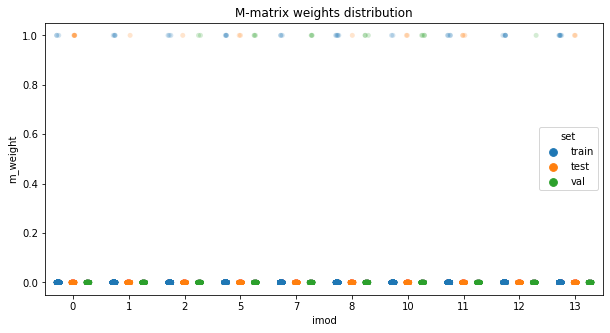

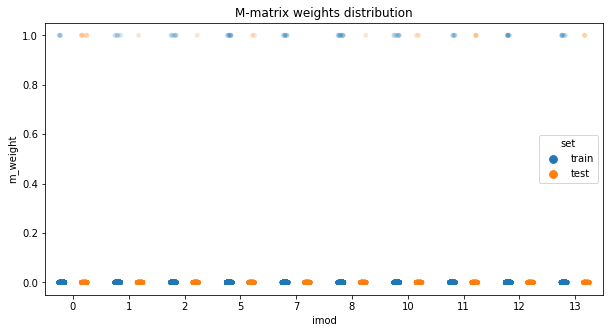

In [33]:
# Split data into train/test/split here and now
full_train_df,test_df = tu.quick_split(XY)
train_df, val_df = tu.quick_split(full_train_df)

print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)


# coi1 = ['0','1','2','3','4']
# coi2 = ['5','6','7','8','9']
# coi3 = ['10','11','12','13','14']
coi1 = imods_filt[:10]
assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])
view_train_test_dist(train_df, test_df,coi1,"M-matrix weights",val_df=val_df)
# view_train_test_dist(train_df, test_df,coi2,"M-matrix weights",val_df=val_df)
# view_train_test_dist(train_df, test_df,coi3,"M-matrix weights",val_df=val_df)

view_train_test_dist(full_train_df, test_df,coi1,"M-matrix weights")


## convert to skorch-able dfs

In [34]:
def make_mt_skorch_dfs(df,seq_col='seq',target_cols=['highCu','noCu']):
    '''
    Make multi-task X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    # number of labels = len(target_cols)
    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [35]:
X, y = make_mt_skorch_dfs(XY, seq_col="upstream_region",target_cols=imods_filt)
print("\nX:",X.shape)
print("y:",y.shape)

Xtrain, ytrain = make_mt_skorch_dfs(train_df, seq_col="upstream_region",target_cols=imods_filt)
print("\nXtrain:",Xtrain.shape)
print("ytrain:",ytrain.shape)

Xval, yval = make_mt_skorch_dfs(val_df, seq_col="upstream_region",target_cols=imods_filt)
print("\nXval:",Xval.shape)
print("yval:",yval.shape)

Xtest, ytest = make_mt_skorch_dfs(test_df, seq_col="upstream_region",target_cols=imods_filt)
print("\nXtest:",Xtest.shape)
print("ytest:",ytest.shape)

Xfull_train, yfull_train = make_mt_skorch_dfs(full_train_df, seq_col="upstream_region",target_cols=imods_filt)
print("\nXfull_train:",Xfull_train.shape)
print("yfull_train:",yfull_train.shape)


X: torch.Size([2129, 300, 4])
y: torch.Size([2129, 58])

Xtrain: torch.Size([1362, 300, 4])
ytrain: torch.Size([1362, 58])

Xval: torch.Size([341, 300, 4])
yval: torch.Size([341, 58])

Xtest: torch.Size([426, 300, 4])
ytest: torch.Size([426, 58])

Xfull_train: torch.Size([1703, 300, 4])
yfull_train: torch.Size([1703, 58])


In [36]:
# make skorch predefined valid ds
# valid_ds = Dataset(Xval, yval)

## pick some params

In [37]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [38]:
from skorch import NeuralNet
import torch.nn as nn
from skorch.dataset import ValidSplit

In [39]:
# apparently i think DNA_2CNN_2FC_Multi should still work for multi-label classification

net_regr1 = NeuralNetClassifier(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    criterion=torch.nn.BCEWithLogitsLoss(),
    train_split=ValidSplit(0.2),
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.01,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=100),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [40]:
net_regr1.fit(Xfull_train, yfull_train)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5907       0.6540        0.4311  1.3791
      2        0.1970       0.6540        0.0467  0.1072
      3        0.0546       0.6540        0.0690  0.1052
      4        0.0632       0.6540        0.0594  0.0802
      5        0.0513       0.6540        0.0484  0.0801
      6        0.0452       0.6540        0.0462  0.0789
      7        0.0439       0.6540        0.0454  0.0765
      8        0.0434       0.6540        0.0451  0.0769
      9        0.0432       0.6540        0.0449  0.0766
     10        0.0430       0.6540        0.0448  0.0767
     11        0.0428       0.6540        0.0448  0.0765
     12        0.0426       0.6540        0.0446  0.0766
     13        0.0425       0.6540        0.0447  0.0765
     14        0.0425       0.6540        0.0449  0.0766
     15        0.0422       0.6540        0.0452  0.0768
     16        0.0422       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=58, bias=True)
    )
  ),
)

In [41]:
pr = net_regr1.predict(Xtest)
pr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [42]:
pr.shape

(426, 58)

# Viz model results

In [43]:
def sk_loss_plot(nets,yscaler=5):
    '''
    Draw the train/val losses from a skorch net
    '''
    
    fig = plt.figure(figsize=(10,5))
    smallest_val = 999
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=1.0,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')
        
        if val_min < smallest_val:
            smallest_val = val_min

    plt.ylim(0,smallest_val*yscaler)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    

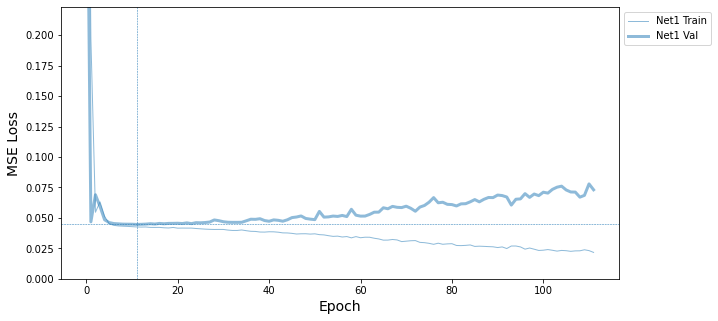

In [44]:
nets = [
    (net_regr1,'Net1'),
]

sk_loss_plot(nets)

In [45]:
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay

In [51]:
#ahhhhh fix thissssss

#def plot_confusion_multi(models,genes,oracle,objs):
def plot_confusion_multi(models,Xs,ys,imods):
    '''Get class predictions and plot confusion matrix'''

    for sk_model,model_name in models:
        #model.eval()
        print(f"Running {model_name}")
        
        y_preds = sk_model.predict(Xs)
        
        confs = multilabel_confusion_matrix(ys, y_preds)

        # display the matrix
        #for i in range(y_preds.shape[1]):
        for i,imod in enumerate(imods):
            mats = []
            c = confs[i]
            mats.append((c,f"raw counts"))
            # get the normalized confusino matrix
            cp = np.zeros(c.shape)
            for i,row in enumerate(c):
                rowsum = sum(row)
                for j,item in enumerate(row):
                    val = item/rowsum
                    cp[i][j] = val

            mats.append((cp,f"normed counts"))
            #print(mats)
            
            f, axes = plt.subplots(1, 2, figsize=(5, 3))#, sharey='row')
            axes = list(axes)
            #axes_list = [item for sublist in axes for item in sublist]
            
            for i,(mat,title) in enumerate(mats):
                disp = ConfusionMatrixDisplay(confusion_matrix=mat)
                #disp.plot(ax=axes_list.pop(0))
                disp.plot(ax=axes.pop(0))
                disp.ax_.set_title(title)
            
            f.suptitle(f"{model_name}, iMod {imod}",fontsize=20)
            #plt.title(f"{model_name}, iMod {imod}")
            plt.tight_layout()
            # plt.show()
        
#    return dfs


Running Net1


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


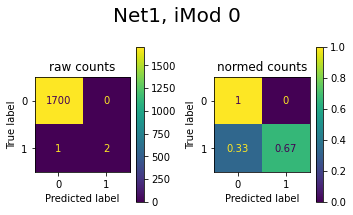

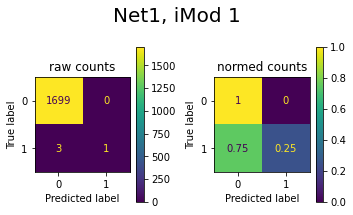

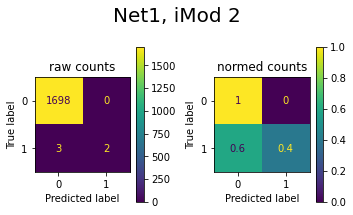

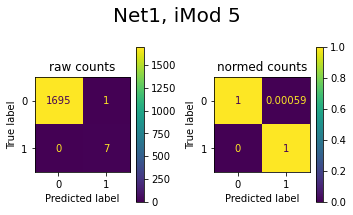

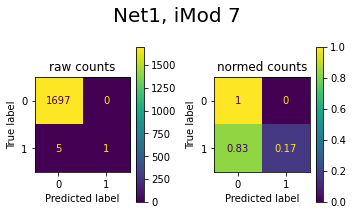

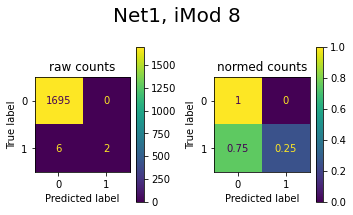

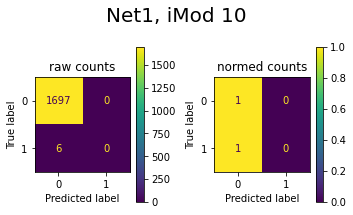

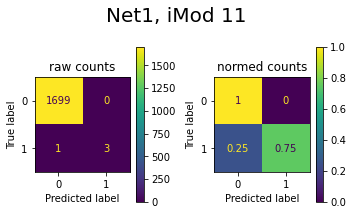

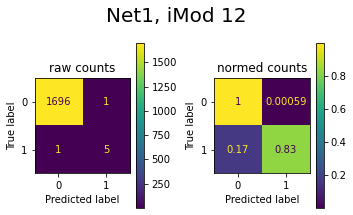

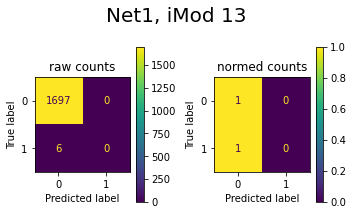

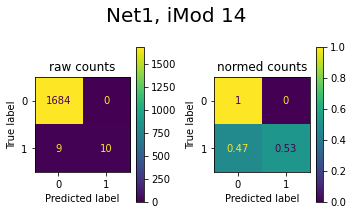

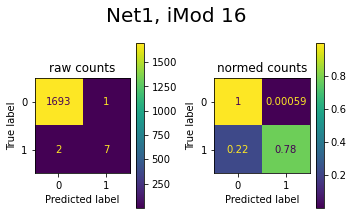

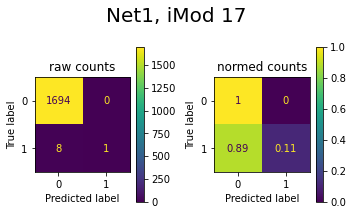

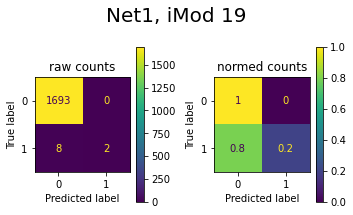

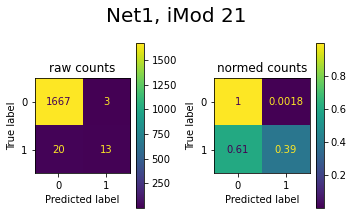

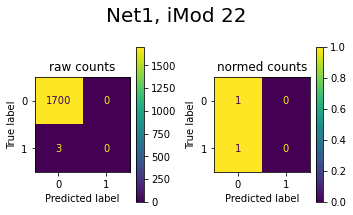

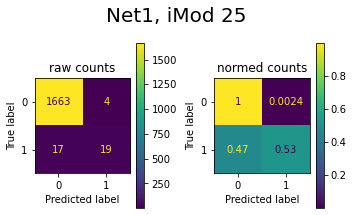

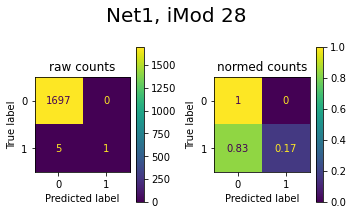

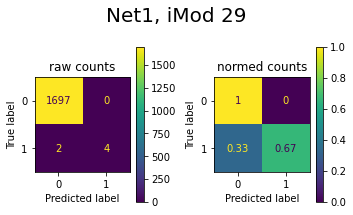

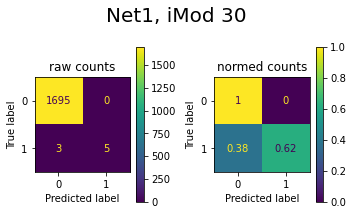

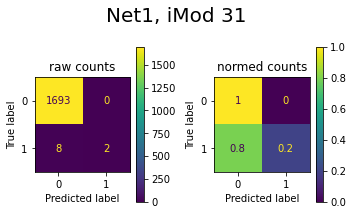

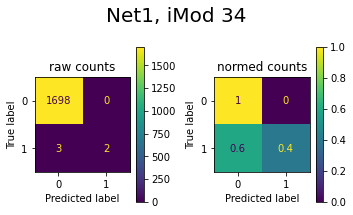

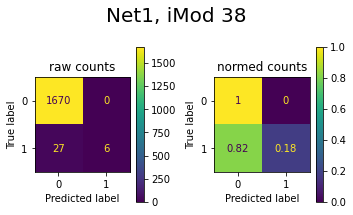

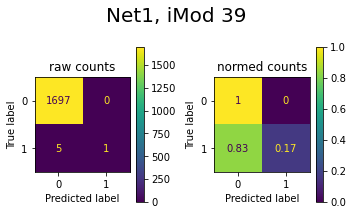

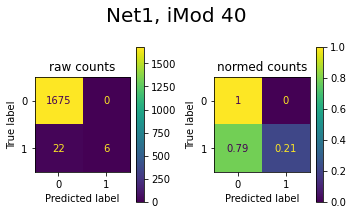

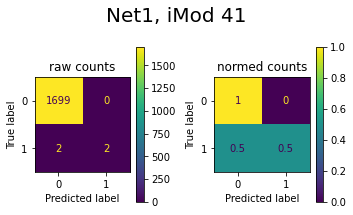

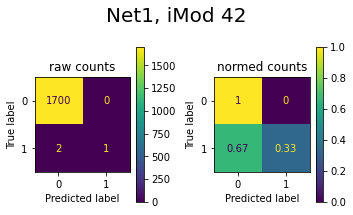

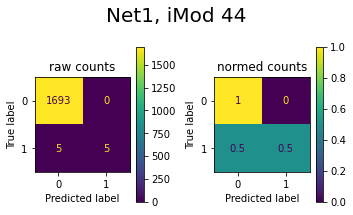

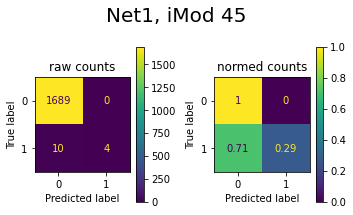

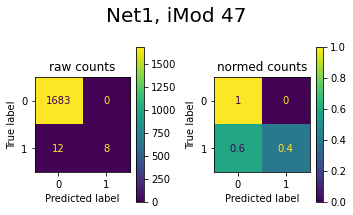

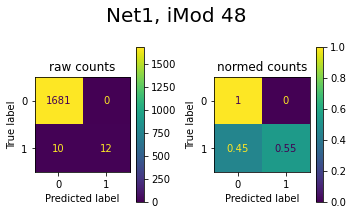

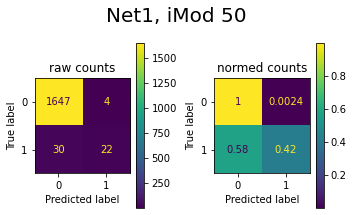

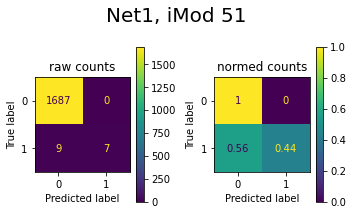

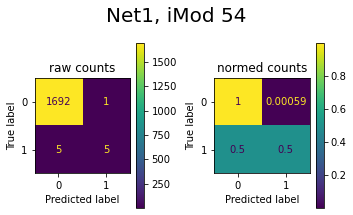

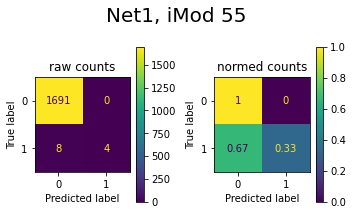

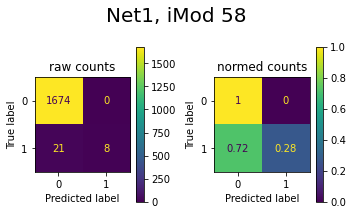

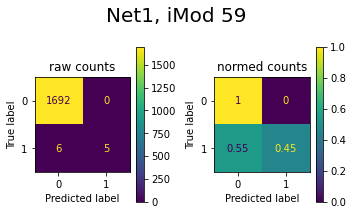

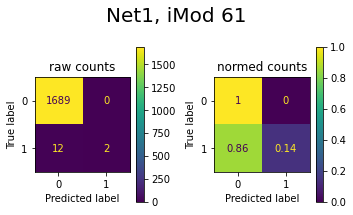

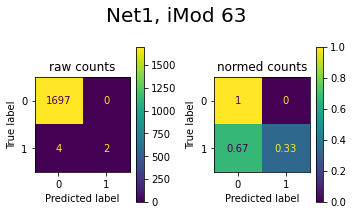

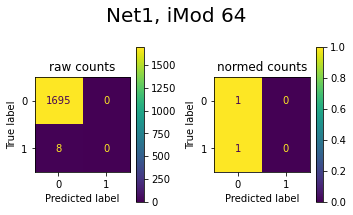

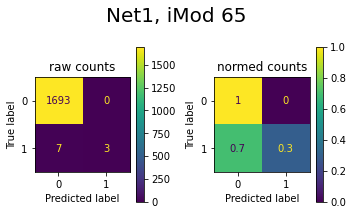

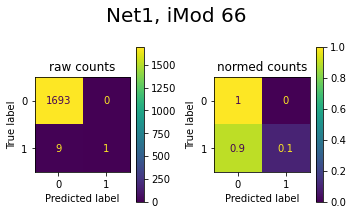

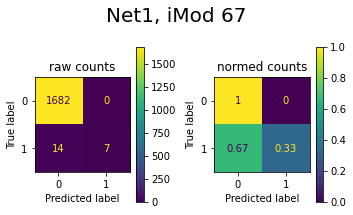

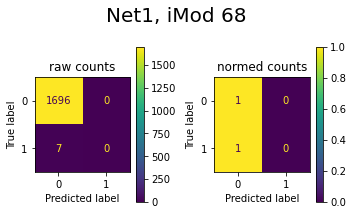

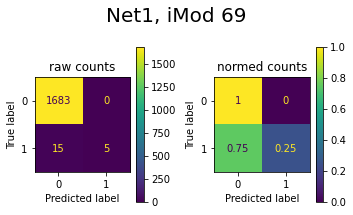

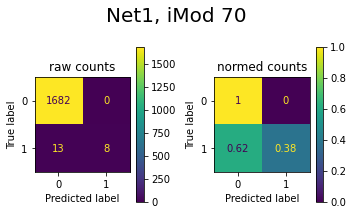

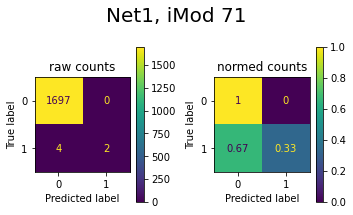

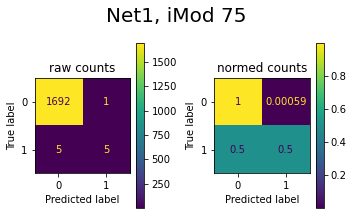

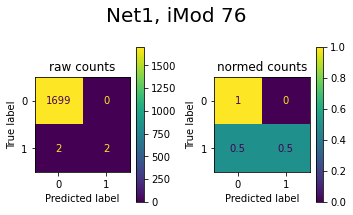

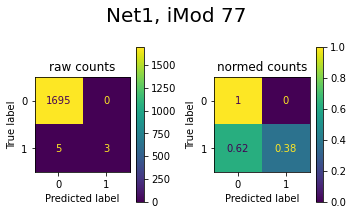

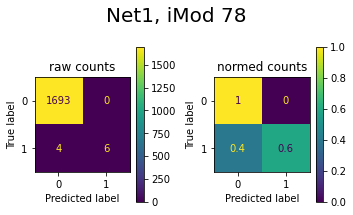

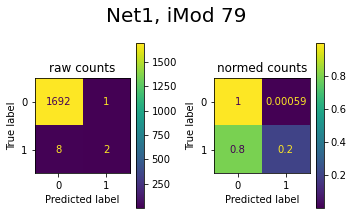

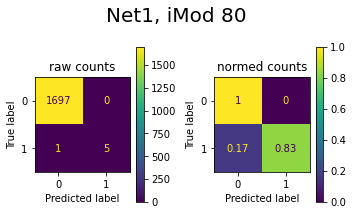

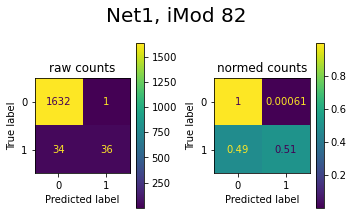

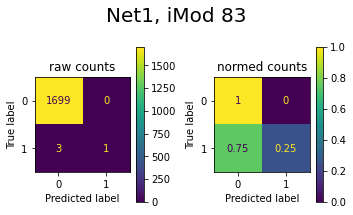

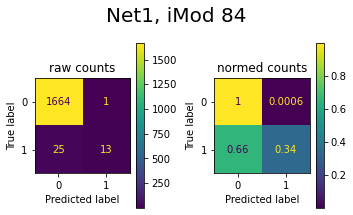

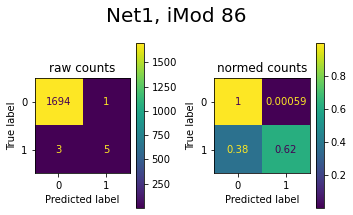

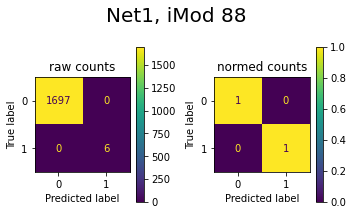

In [52]:
plot_confusion_multi(nets, Xfull_train,yfull_train,imods_filt)

In [59]:
#plot_confusion_multi(nets, Xtest,ytest,imods_filt)

In [78]:
from sklearn.metrics import classification_report

In [190]:
def alt_cls_summary(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color='score:Q',
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_circle().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        size='support:Q',
        tooltip=['support']
    ).properties(width=600)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def alt_cls_summary2(df):
    heat = alt.Chart(df).mark_rect().encode(
        x=alt.X('imod:O'),
        y=alt.Y('metric:O'),
        color='score:Q',
        tooltip=['metric:N','score:Q']
    ).properties(width=600)

    support = alt.Chart(df).mark_bar().encode(
        x=alt.X('imod:O',title='',axis=alt.Axis(labels=False)),
        color=alt.Color('support:Q', legend=None,scale=alt.Scale(scheme='greys')),
        y='support:Q',
        tooltip=['support']
    ).properties(width=600,height=50)

    return alt.vconcat(support,heat
        ).resolve_scale(color='independent'
        ).configure_concat(
            spacing=0
        )

def view_cls_report(sk_model,Xs,ys,imods):
    '''
    For a given model and set of X,y examples, save and display 
    a summary of the primary classification metrics
    '''
    # get the predictions and classification report
    y_preds = sk_model.predict(Xs)
    cls_rep = classification_report(ys, y_preds,target_names=imods,output_dict=True)
    
    # conver the dict into a df for viewing
    cls_df = pd.DataFrame.from_dict(cls_rep,orient='index')
    cls_df.index.name='imod'
    cls_df = cls_df.reset_index()
    
    # drop the micro/macro average colums
    cls_df = cls_df.drop(cls_df[~cls_df['imod'].isin(imods)].index)
    # convert to int for sorting
    cls_df['imod'] = cls_df['imod'].apply(lambda x: int(x))
    
    # melt the df for altair
    cls_melt = cls_df.melt(
        id_vars=['imod','support'],
        value_vars=['precision','recall','f1-score'],
        var_name='metric',
        value_name='score')
    
    #alt_cls_summary(cls_melt)
    display(alt_cls_summary2(cls_melt))

    return cls_df
    
    
    

In [194]:
cls_full_train_df = view_cls_report(net_regr1,Xfull_train,yfull_train,imods_filt)
cls_test_df = view_cls_report(net_regr1,Xtest,ytest,imods_filt)

alt.VConcatChart(...)

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


alt.VConcatChart(...)

For all tasks, defaulting to about 0, aka "not in iModulon"
* are any iMods better than others?
* do an initial skorch search to see if any hyperparams stand out?
* then dip back to data aug... cross val
* mbinarized



# SKORCH search

In [15]:
from sklearn.model_selection import RandomizedSearchCV


In [22]:
net_search = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi,
    #m.DNA_2CNN_Multi,
    #m.DNA_CNN_Multi,
    module__seq_len=300,
    module__n_tasks=y.shape[1],
    max_epochs=2000,
    #lr=0.001,
    device=DEVICE,
    callbacks=[
         EarlyStopping(patience=500),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    verbose=0,

)

In [24]:
params = {
    'lr': [0.01, 0.001, 0.0001,],#loguniform(0.0001, 0.01)
    
    'module__num_filters1': [16,32,64,128],
    'module__num_filters2': [16,32,64,128],
    'module__kernel_size1': [4,8,16,32],
    'module__kernel_size2': [4,8,16,32],
    'module__conv_pool_size1': [2,4,8,16],
    'module__fc_node_num1': [10,50,100,500],
    'module__fc_node_num2': [10,50,100,500],
    'module__dropout1': [0.0,0.2,0.4],
    'module__dropout2': [0.0,0.2,0.4],
    'optimizer':[torch.optim.SGD, torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
}

In [25]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=100, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=7,
    verbose=1
)

In [26]:
search.fit(Xfull_train,yfull_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 102.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 136.9min finished


RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class 'models.DNA_2CNN_2FC_Multi'>,
  module__n_tasks=92,
  module__seq_len=300,
),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'lr': [0.01, 0.001, 0.0001],
                                        'module__conv_pool_size1': [2, 4, 8,
                                                                    16],
                                        'module__dropout1': [0.0, 0.2, 0.4],
                                        'module__dropout2': [0.0, 0.2, 0.4],
                                        'mo...
                                                                 500],
                                        'module__kernel_size1': [4, 8, 16, 32],
                                        'module__kernel_size2': [4, 8, 16, 32],
                                        'module__num_filters1': [16, 32, 64,
                    

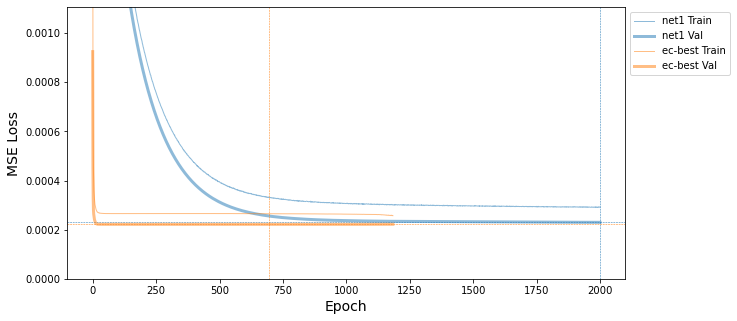

In [28]:
nets = [
    (net_regr1,"net1"),
    (search.best_estimator_,'ec-best')
]

sk_loss_plot(nets)

### inspect hyperparam search results

In [29]:
search.best_estimator_

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 16), stride=(1, 16), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.4, inplace=False)
      (4): Conv2d(16, 128, kernel_size=(1, 16), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.4, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=384, out_features=50, bias=True)
      (9): ReLU()
      (10): Linear(in_features=50, out_features=500, bias=True)
      (11): ReLU()
      (12): Linear(in_features=500, out_features=92, bias=True)
    )
  ),
)

In [30]:
search.best_params_

{'optimizer': torch.optim.adamw.AdamW,
 'module__num_filters2': 128,
 'module__num_filters1': 16,
 'module__kernel_size2': 16,
 'module__kernel_size1': 8,
 'module__fc_node_num2': 500,
 'module__fc_node_num1': 50,
 'module__dropout2': 0.4,
 'module__dropout1': 0.4,
 'module__conv_pool_size1': 16,
 'lr': 0.0001}

In [31]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters2,param_module__num_filters1,param_module__kernel_size2,param_module__kernel_size1,param_module__fc_node_num2,...,param_module__conv_pool_size1,param_lr,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,71.967057,12.216083,0.021500,0.001165,<class 'torch.optim.rmsprop.RMSprop'>,128,64,16,4,10,...,16,0.01,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000296,-0.000311,-0.000346,-0.000318,0.000021,72,RMSprop
1,163.493714,9.668032,0.018877,0.001166,<class 'torch.optim.sgd.SGD'>,32,16,32,4,50,...,2,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-0.006479,-0.007145,-0.006745,-0.006790,0.000274,92,SGD
2,41.803676,1.812703,0.021897,0.002649,<class 'torch.optim.adam.Adam'>,64,32,4,16,10,...,16,0.01,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-0.000237,-0.000253,-0.000289,-0.000260,0.000022,16,Adam
3,0.007967,0.000205,0.000000,0.000000,<class 'torch.optim.adamw.AdamW'>,32,128,32,8,100,...,16,0.01,{'optimizer': <class 'torch.optim.adamw.AdamW'...,NaN,NaN,NaN,NaN,NaN,100,AdamW
4,67.520009,29.807880,0.017562,0.000624,<class 'torch.optim.rmsprop.RMSprop'>,16,32,32,4,10,...,4,0.001,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000239,-0.000255,-0.000291,-0.000262,0.000022,23,RMSprop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,46.600638,20.220994,0.017378,0.000783,<class 'torch.optim.rmsprop.RMSprop'>,16,16,8,32,50,...,4,0.01,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000296,-0.000308,-0.000346,-0.000317,0.000021,63,RMSprop
96,74.883984,12.679929,0.018746,0.001701,<class 'torch.optim.adamw.AdamW'>,128,64,8,16,10,...,8,0.0001,{'optimizer': <class 'torch.optim.adamw.AdamW'...,-0.000429,-0.000292,-0.000362,-0.000361,0.000056,78,AdamW
97,123.845607,46.760401,0.020805,0.000315,<class 'torch.optim.adamw.AdamW'>,128,16,16,16,10,...,8,0.0001,{'optimizer': <class 'torch.optim.adamw.AdamW'...,-0.000242,-0.000269,-0.000297,-0.000270,0.000022,42,AdamW
98,178.359135,2.837735,0.022018,0.003054,<class 'torch.optim.sgd.SGD'>,128,128,8,16,10,...,16,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-0.030090,-0.036958,-0.036385,-0.034478,0.003112,96,SGD


In [32]:
sm_res_df = res_df[[
    "rank_test_score",
    "mean_test_score",
    "param_module__num_filters1",
    "param_module__num_filters2",
    "param_module__kernel_size1",
    "param_module__kernel_size2",
    "param_lr",
    "param_module__fc_node_num1",
    "param_module__fc_node_num2",
    "opt_name"]]

In [33]:
sm_res_df

,rank_test_score,mean_test_score,param_module__num_filters1,param_module__num_filters2,param_module__kernel_size1,param_module__kernel_size2,param_lr,param_module__fc_node_num1,param_module__fc_node_num2,opt_name
0,72,-0.000318,64,128,4,16,0.01,500,10,RMSprop
1,92,-0.006790,16,32,4,32,0.0001,100,50,SGD
2,16,-0.000260,32,64,16,4,0.01,10,10,Adam
3,100,NaN,128,32,8,32,0.01,100,100,AdamW
4,23,-0.000262,32,16,4,32,0.001,50,10,RMSprop
...,...,...,...,...,...,...,...,...,...,...
95,63,-0.000317,16,16,32,8,0.01,50,50,RMSprop
96,78,-0.000361,64,128,16,8,0.0001,50,10,AdamW
97,42,-0.000270,16,128,16,16,0.0001,500,10,AdamW
98,96,-0.034478,128,128,16,8,0.0001,50,10,SGD


In [34]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    #shape="param_module__kernel_size1:N"
    
).interactive()

alt.Chart(...)

In [35]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__kernel_size1:O',title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='param_module__num_filters1:N',
#     detail='model_desc:N',
    shape="opt_name:N",
    tooltip=["rank_test_score:O","param_module__num_filters1:N","param_module__kernel_size1:N","param_lr:N","param_module__fc_node_num1:N"]
    
).interactive()

alt.Chart(...)

In [37]:
alt.Chart(sm_res_df).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [38]:
alt.Chart(sm_res_df[~sm_res_df['opt_name'].isin(['SGD'])]).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [39]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__kernel_size1:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [41]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__fc_node_num1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__fc_node_num2:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [42]:
res_df.to_csv('ec_iMod_out/hyper100_1.tsv',sep='\t',index=False)

## Retry with older arch without multiple fc layers

In [16]:
net_search = NeuralNetRegressor(
    #m.DNA_2CNN_2FC_Multi,
    m.DNA_2CNN_Multi,
    #m.DNA_CNN_Multi,
    module__seq_len=300,
    module__n_tasks=y.shape[1],
    max_epochs=2000,
    #lr=0.001,
    device=DEVICE,
    callbacks=[
         EarlyStopping(patience=500),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    verbose=0,

)

In [17]:
params = {
    'lr': [0.01, 0.001, 0.0001,],#loguniform(0.0001, 0.01)
    
    'module__num_filters1': [16,32,64,128],
    'module__num_filters2': [16,32,64,128],
    'module__kernel_size1': [4,8,16,32],
    'module__kernel_size2': [4,8,16,32],
    'module__conv_pool_size1': [2,4,8,16],
    'module__fc_node_num1': [10,50,100,500],
    #'module__fc_node_num2': [10,50,100,500],
    'module__dropout1': [0.0,0.2,0.4],
    'module__dropout2': [0.0,0.2,0.4],
    'optimizer':[torch.optim.SGD, torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
}

In [18]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=100, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=7,
    verbose=1
)

In [19]:
search.fit(Xfull_train,yfull_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 91.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 122.1min finished


RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class 'models.DNA_2CNN_Multi'>,
  module__n_tasks=92,
  module__seq_len=300,
),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'lr': [0.01, 0.001, 0.0001],
                                        'module__conv_pool_size1': [2, 4, 8,
                                                                    16],
                                        'module__dropout1': [0.0, 0.2, 0.4],
                                        'module__dropout2': [0.0, 0.2, 0.4],
                                        'module...
                                                                 500],
                                        'module__kernel_size1': [4, 8, 16, 32],
                                        'module__kernel_size2': [4, 8, 16, 32],
                                        'module__num_filters1': [16, 32, 64,
                    

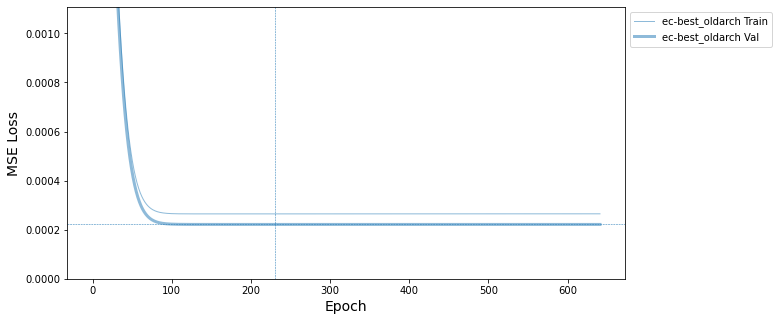

In [20]:
nets = [
    (search.best_estimator_,'ec-best_oldarch')
]

sk_loss_plot(nets)

In [21]:
search.best_params_

{'optimizer': torch.optim.adam.Adam,
 'module__num_filters2': 128,
 'module__num_filters1': 128,
 'module__kernel_size2': 16,
 'module__kernel_size1': 4,
 'module__fc_node_num1': 500,
 'module__dropout2': 0.4,
 'module__dropout1': 0.0,
 'module__conv_pool_size1': 4,
 'lr': 0.01}

In [22]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters2,param_module__num_filters1,param_module__kernel_size2,param_module__kernel_size1,param_module__fc_node_num1,...,param_module__conv_pool_size1,param_lr,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,69.854427,1.431914,0.020253,0.002287,<class 'torch.optim.rmsprop.RMSprop'>,128,64,16,4,10,...,4,0.01,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000296,-0.000311,-0.000346,-0.000318,0.000021,68,RMSprop
1,116.072528,8.235395,0.017485,0.002049,<class 'torch.optim.sgd.SGD'>,32,16,32,4,50,...,4,0.001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-0.002919,-0.002826,-0.002597,-0.002781,0.000135,86,SGD
2,30.852906,5.040905,0.015583,0.000968,<class 'torch.optim.adam.Adam'>,64,32,4,16,10,...,4,0.01,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-0.000236,-0.000252,-0.000287,-0.000258,0.000022,12,Adam
3,52.986956,4.351898,0.021289,0.002168,<class 'torch.optim.adamw.AdamW'>,32,128,32,8,100,...,2,0.01,{'optimizer': <class 'torch.optim.adamw.AdamW'...,-0.000235,-0.000251,-0.000287,-0.000258,0.000022,6,AdamW
4,46.948207,1.685851,0.019074,0.000857,<class 'torch.optim.rmsprop.RMSprop'>,16,16,8,16,50,...,8,0.001,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000247,-0.000273,-0.000301,-0.000274,0.000022,38,RMSprop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,87.054811,7.078445,0.021393,0.000193,<class 'torch.optim.adamw.AdamW'>,64,128,16,32,50,...,8,0.0001,{'optimizer': <class 'torch.optim.adamw.AdamW'...,-0.000240,-0.000256,-0.000290,-0.000262,0.000021,26,AdamW
96,51.073176,3.056556,0.018012,0.002369,<class 'torch.optim.rmsprop.RMSprop'>,128,64,4,4,10,...,4,0.001,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000237,-0.000253,-0.000289,-0.000260,0.000022,21,RMSprop
97,95.923561,0.919165,0.015507,0.000163,<class 'torch.optim.sgd.SGD'>,16,32,4,32,10,...,4,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-0.027813,-0.028178,-0.029007,-0.028333,0.000500,91,SGD
98,91.409367,0.486924,0.012548,0.002419,<class 'torch.optim.sgd.SGD'>,128,16,4,16,100,...,8,0.01,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-0.000293,-0.000287,-0.000360,-0.000313,0.000033,57,SGD


In [24]:
sm_res_df = res_df[[
    "rank_test_score",
    "mean_test_score",
    "param_module__num_filters1",
    "param_module__num_filters2",
    "param_module__kernel_size1",
    "param_module__kernel_size2",
    "param_lr",
    "param_module__fc_node_num1",
    #"param_module__fc_node_num2",
    "opt_name"]]

sm_res_df

,rank_test_score,mean_test_score,param_module__num_filters1,param_module__num_filters2,param_module__kernel_size1,param_module__kernel_size2,param_lr,param_module__fc_node_num1,opt_name
0,68,-0.000318,64,128,4,16,0.01,10,RMSprop
1,86,-0.002781,16,32,4,32,0.001,50,SGD
2,12,-0.000258,32,64,16,4,0.01,10,Adam
3,6,-0.000258,128,32,8,32,0.01,100,AdamW
4,38,-0.000274,16,16,16,8,0.001,50,RMSprop
...,...,...,...,...,...,...,...,...,...
95,26,-0.000262,128,64,32,16,0.0001,50,AdamW
96,21,-0.000260,64,128,4,4,0.001,10,RMSprop
97,91,-0.028333,32,16,32,4,0.0001,10,SGD
98,57,-0.000313,16,128,16,4,0.01,100,SGD


In [27]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size1:N"
    
).interactive()

alt.Chart(...)

In [32]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__fc_node_num1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__num_filters1:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [33]:
res_df.to_csv('ec_iMod_out/hyper100_2.tsv',sep='\t',index=False)

## compare against each other?

In [23]:
res_df1 = pd.read_csv('ec_iMod_out/hyper100_1.tsv',sep='\t')
res_df1['run'] = 1

res_df2 = pd.read_csv('ec_iMod_out/hyper100_2.tsv',sep='\t')
res_df2['run']=2

In [28]:
comb_df = pd.concat([res_df1,res_df2])
comb_df = comb_df[[
    "rank_test_score",
    "mean_test_score",
    "param_module__num_filters1",
    "param_module__num_filters2",
    "param_module__kernel_size1",
    "param_module__kernel_size2",
    "param_lr",
    "param_module__fc_node_num1",
    #"param_module__fc_node_num2",
    "opt_name", "run"]]

In [29]:
comb_df

,rank_test_score,mean_test_score,param_module__num_filters1,param_module__num_filters2,param_module__kernel_size1,param_module__kernel_size2,param_lr,param_module__fc_node_num1,opt_name,run
0,72,-0.000318,64,128,4,16,0.0100,500,RMSprop,1
1,92,-0.006790,16,32,4,32,0.0001,100,SGD,1
2,16,-0.000260,32,64,16,4,0.0100,10,Adam,1
3,100,NaN,128,32,8,32,0.0100,100,AdamW,1
4,23,-0.000262,32,16,4,32,0.0010,50,RMSprop,1
...,...,...,...,...,...,...,...,...,...,...
95,26,-0.000262,128,64,32,16,0.0001,50,AdamW,2
96,21,-0.000260,64,128,4,4,0.0010,10,RMSprop,2
97,91,-0.028333,32,16,32,4,0.0001,10,SGD,2
98,57,-0.000313,16,128,16,4,0.0100,100,SGD,2


In [30]:
alt.Chart(comb_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='run:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [31]:
alt.Chart(comb_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__kernel_size1:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

## try cros_val_predict

In [ ]:
# {'optimizer': torch.optim.adam.Adam,
#  'module__num_filters2': 128,
#  'module__num_filters1': 128,
#  'module__kernel_size2': 16,
#  'module__kernel_size1': 4,
#  'module__fc_node_num1': 500,
#  'module__dropout2': 0.4,
#  'module__dropout1': 0.0,
#  'module__conv_pool_size1': 4,
#  'lr': 0.01}

In [55]:
net_regr_man = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=4,
    module__kernel_size2=16,
    module__conv_pool_size1=4, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 500,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.01,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)

In [56]:
from sklearn.model_selection import cross_val_predict

In [57]:
y_pred = cross_val_predict(net_regr_man, X, y, cv=5)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      786.0800        0.0009     +  0.1267
      2        0.0008        0.0008     +  0.1091
      3        0.0005        0.0003     +  0.1041
      4        0.0003        0.0003     +  0.0953
      5        0.0003        0.0003     +  0.0880
      6        0.0003        0.0003     +  0.0831
      7        0.0003        0.0003     +  0.0831
      8        0.0003        0.0003     +  0.0817
      9        0.0003        0.0003     +  0.0818
     10        0.0003        0.0003     +  0.0820
     11        0.0003        0.0003        0.0831
     12        0.0003        0.0003        0.0819
     13        0.0003        0.0003        0.0814
     14        0.0003        0.0003        0.0817
     15        0.0003        0.0003        0.0815
     16        0.0003        0.0003     +  0.0816
     17        0.0003        0.0003        0.0820
     18        0.0003        0.0003        0.0814


    160        0.0003        0.0003        0.0813
    161        0.0003        0.0003        0.0819
    162        0.0003        0.0003        0.0814
    163        0.0003        0.0003        0.0813
    164        0.0003        0.0003        0.0812
    165        0.0003        0.0003        0.0816
    166        0.0003        0.0003        0.0816
    167        0.0003        0.0003        0.0816
    168        0.0003        0.0003        0.0816
    169        0.0003        0.0003        0.0816
    170        0.0003        0.0003        0.0815
    171        0.0003        0.0003        0.0816
    172        0.0003        0.0003        0.0816
    173        0.0003        0.0003        0.0818
    174        0.0003        0.0003        0.0815
    175        0.0003        0.0003        0.0812
    176        0.0003        0.0003        0.0811
    177        0.0003        0.0003        0.0814
    178        0.0003        0.0003        0.0817
    179        0.0003        0.0003        0.0816


    324        0.0003        0.0003        0.0814
    325        0.0003        0.0003        0.0813
    326        0.0003        0.0003        0.0816
    327        0.0003        0.0003        0.0814
    328        0.0003        0.0003        0.0814
    329        0.0003        0.0003        0.0815
    330        0.0003        0.0003        0.0814
    331        0.0003        0.0003        0.0818
    332        0.0003        0.0003        0.0817
    333        0.0003        0.0003        0.0814
    334        0.0003        0.0003        0.0813
    335        0.0003        0.0003        0.0816
    336        0.0003        0.0003        0.0812
    337        0.0003        0.0003        0.0820
    338        0.0003        0.0003        0.0818
    339        0.0003        0.0003        0.0815
    340        0.0003        0.0003        0.0815
    341        0.0003        0.0003        0.0817
    342        0.0003        0.0003        0.0822
    343        0.0003        0.0003        0.0817


    488        0.0003        0.0003        0.0821
    489        0.0003        0.0003        0.0825
    490        0.0003        0.0003        0.0824
    491        0.0003        0.0003        0.0837
    492        0.0003        0.0003        0.0821
    493        0.0003        0.0003        0.0818
    494        0.0003        0.0003        0.0820
    495        0.0003        0.0003        0.0819
    496        0.0003        0.0003        0.0816
    497        0.0003        0.0003        0.0819
    498        0.0003        0.0003        0.0815
    499        0.0003        0.0003        0.0813
    500        0.0003        0.0003        0.0815
    501        0.0003        0.0003        0.0814
    502        0.0003        0.0003        0.0814
    503        0.0003        0.0003        0.0815
    504        0.0003        0.0003        0.0823
    505        0.0003        0.0003        0.0821
    506        0.0003        0.0003        0.0817
    507        0.0003        0.0003        0.0818


    130        0.0003        0.0002        0.0815
    131        0.0003        0.0002        0.0817
    132        0.0003        0.0002        0.0813
    133        0.0003        0.0002        0.0812
    134        0.0003        0.0002        0.0816
    135        0.0003        0.0002        0.0818
    136        0.0003        0.0002        0.0814
    137        0.0003        0.0002        0.0813
    138        0.0003        0.0002        0.0814
    139        0.0003        0.0002        0.0816
    140        0.0003        0.0002        0.0817
    141        0.0003        0.0002        0.0820
    142        0.0003        0.0002        0.0822
    143        0.0003        0.0002        0.0819
    144        0.0003        0.0002        0.0822
    145        0.0003        0.0002        0.0820
    146        0.0003        0.0002        0.0820
    147        0.0003        0.0002        0.0821
    148        0.0003        0.0002        0.0820
    149        0.0003        0.0002        0.0820


    294        0.0003        0.0002        0.0817
    295        0.0003        0.0002        0.0815
    296        0.0003        0.0002        0.0818
    297        0.0003        0.0002        0.0820
    298        0.0003        0.0002        0.0818
    299        0.0003        0.0002        0.0815
    300        0.0003        0.0002        0.0817
    301        0.0003        0.0002        0.0813
    302        0.0003        0.0002        0.0815
    303        0.0003        0.0002        0.0817
    304        0.0003        0.0002        0.0813
    305        0.0003        0.0002        0.0817
    306        0.0003        0.0002        0.0814
    307        0.0003        0.0002        0.0815
    308        0.0003        0.0002        0.0816
    309        0.0003        0.0002        0.0815
    310        0.0003        0.0002        0.0816
    311        0.0003        0.0002        0.0816
    312        0.0003        0.0002        0.0819
    313        0.0003        0.0002        0.0819


    458        0.0003        0.0002        0.0817
    459        0.0003        0.0002        0.0819
    460        0.0003        0.0002        0.0819
    461        0.0003        0.0002        0.0817
    462        0.0003        0.0002        0.0818
    463        0.0003        0.0002        0.0819
    464        0.0003        0.0002        0.0820
    465        0.0003        0.0002        0.0818
    466        0.0003        0.0002        0.0817
    467        0.0003        0.0002        0.0821
    468        0.0003        0.0002        0.0817
    469        0.0003        0.0002        0.0816
    470        0.0003        0.0002        0.0819
    471        0.0003        0.0002        0.0820
    472        0.0003        0.0002        0.0816
    473        0.0003        0.0002        0.0816
    474        0.0003        0.0002        0.0816
    475        0.0003        0.0002        0.0815
    476        0.0003        0.0002        0.0815
    477        0.0003        0.0002        0.0821


    108        0.0003        0.0002        0.0815
    109        0.0003        0.0002        0.0820
    110        0.0003        0.0002        0.0821
    111        0.0003        0.0002        0.0817
    112        0.0003        0.0002        0.0819
    113        0.0003        0.0002        0.0819
    114        0.0003        0.0002        0.0815
    115        0.0003        0.0002        0.0817
    116        0.0003        0.0002        0.0819
    117        0.0003        0.0002        0.0815
    118        0.0003        0.0002        0.0816
    119        0.0003        0.0002        0.0818
    120        0.0003        0.0002        0.0816
    121        0.0003        0.0002        0.0815
    122        0.0003        0.0002        0.0820
    123        0.0003        0.0002        0.0817
    124        0.0003        0.0002        0.0814
    125        0.0003        0.0002        0.0818
    126        0.0003        0.0002        0.0817
    127        0.0003        0.0002        0.0814


    272        0.0003        0.0002        0.0818
    273        0.0003        0.0002        0.0816
    274        0.0003        0.0002        0.0815
    275        0.0003        0.0002        0.0815
    276        0.0003        0.0002        0.0818
    277        0.0003        0.0002        0.0815
    278        0.0003        0.0002        0.0815
    279        0.0003        0.0002        0.0819
    280        0.0003        0.0002        0.0816
    281        0.0003        0.0002        0.0813
    282        0.0003        0.0002        0.0816
    283        0.0003        0.0002        0.0817
    284        0.0003        0.0002        0.0814
    285        0.0003        0.0002        0.0815
    286        0.0003        0.0002        0.0818
    287        0.0003        0.0002        0.0813
    288        0.0003        0.0002        0.0815
    289        0.0003        0.0002        0.0813
    290        0.0003        0.0002        0.0816
    291        0.0003        0.0002        0.0815


    436        0.0003        0.0002        0.0820
    437        0.0003        0.0002        0.0817
    438        0.0003        0.0002        0.0817
    439        0.0003        0.0002        0.0816
    440        0.0003        0.0002        0.0816
    441        0.0003        0.0002        0.0817
    442        0.0003        0.0002        0.0818
    443        0.0003        0.0002        0.0820
    444        0.0003        0.0002        0.0819
    445        0.0003        0.0002        0.0820
    446        0.0003        0.0002        0.0821
    447        0.0003        0.0002        0.0824
    448        0.0003        0.0002        0.0824
    449        0.0003        0.0002        0.0824
    450        0.0003        0.0002        0.0824
    451        0.0003        0.0002        0.0824
    452        0.0003        0.0002        0.0820
    453        0.0003        0.0002        0.0823
    454        0.0003        0.0002        0.0820
    455        0.0003        0.0002        0.0820


     85        0.0003        0.0002        0.0823
     86        0.0003        0.0002        0.0823
     87        0.0003        0.0002        0.0827
     88        0.0003        0.0002        0.0822
     89        0.0003        0.0002        0.0819
     90        0.0003        0.0002        0.0820
     91        0.0003        0.0002        0.0821
     92        0.0003        0.0002        0.0820
     93        0.0003        0.0002        0.0824
     94        0.0003        0.0002        0.0822
     95        0.0003        0.0002        0.0828
     96        0.0003        0.0002        0.0825
     97        0.0003        0.0002        0.0816
     98        0.0003        0.0002        0.0823
     99        0.0003        0.0002        0.0824
    100        0.0003        0.0002        0.0822
    101        0.0003        0.0002        0.0826
    102        0.0003        0.0002        0.0819
    103        0.0003        0.0002        0.0816
    104        0.0003        0.0002        0.0816


    249        0.0003        0.0002        0.0818
    250        0.0003        0.0002        0.0821
    251        0.0003        0.0002        0.0822
    252        0.0003        0.0002        0.0818
    253        0.0003        0.0002        0.0825
    254        0.0003        0.0002        0.0818
    255        0.0003        0.0002        0.0817
    256        0.0003        0.0002        0.0818
    257        0.0003        0.0002        0.0817
    258        0.0003        0.0002        0.0820
    259        0.0003        0.0002        0.0824
    260        0.0003        0.0002        0.0823
    261        0.0003        0.0002        0.0817
    262        0.0003        0.0002        0.0823
    263        0.0003        0.0002        0.0818
    264        0.0003        0.0002        0.0817
    265        0.0003        0.0002        0.0818
    266        0.0003        0.0002        0.0816
    267        0.0003        0.0002        0.0814
    268        0.0003        0.0002        0.0819


    413        0.0003        0.0002        0.0828
    414        0.0003        0.0002        0.0833
    415        0.0003        0.0002        0.0831
    416        0.0003        0.0002        0.0824
    417        0.0003        0.0002        0.0827
    418        0.0003        0.0002        0.0827
    419        0.0003        0.0002        0.0821
    420        0.0003        0.0002        0.0819
    421        0.0003        0.0002        0.0823
    422        0.0003        0.0002        0.0826
    423        0.0003        0.0002        0.0824
    424        0.0003        0.0002        0.0824
    425        0.0003        0.0002        0.0826
    426        0.0003        0.0002        0.0834
    427        0.0003        0.0002        0.0833
    428        0.0003        0.0002        0.0830
    429        0.0003        0.0002        0.0824
    430        0.0003        0.0002        0.0823
    431        0.0003        0.0002        0.0827
    432        0.0003        0.0002        0.0825


     61        0.0003        0.0002        0.0828
     62        0.0003        0.0002        0.0828
     63        0.0003        0.0002        0.0823
     64        0.0003        0.0002        0.0830
     65        0.0003        0.0002        0.0822
     66        0.0003        0.0002        0.0825
     67        0.0003        0.0002        0.0821
     68        0.0003        0.0002        0.0818
     69        0.0003        0.0002        0.0821
     70        0.0003        0.0002        0.0821
     71        0.0003        0.0002        0.0825
     72        0.0003        0.0002        0.0824
     73        0.0003        0.0002        0.0822
     74        0.0003        0.0002        0.0824
     75        0.0003        0.0002        0.0825
     76        0.0003        0.0002        0.0825
     77        0.0003        0.0002        0.0827
     78        0.0003        0.0002        0.0828
     79        0.0003        0.0002        0.0826
     80        0.0003        0.0002        0.0821


    225        0.0003        0.0002        0.0824
    226        0.0003        0.0002        0.0825
    227        0.0003        0.0002        0.0825
    228        0.0003        0.0002        0.0825
    229        0.0003        0.0002        0.0819
    230        0.0003        0.0002        0.0823
    231        0.0003        0.0002        0.0828
    232        0.0003        0.0002        0.0827
    233        0.0003        0.0003        0.0829
    234        0.0003        0.0002        0.0829
    235        0.0003        0.0002        0.0828
    236        0.0003        0.0002        0.0819
    237        0.0003        0.0002        0.0830
    238        0.0003        0.0002        0.0825
    239        0.0003        0.0002        0.0825
    240        0.0003        0.0002        0.0827
    241        0.0003        0.0002        0.0819
    242        0.0003        0.0002        0.0823
    243        0.0003        0.0002        0.0824
    244        0.0003        0.0002        0.0818


    389        0.0003        0.0002        0.0826
    390        0.0003        0.0002        0.0824
    391        0.0003        0.0002        0.0833
    392        0.0003        0.0002        0.0829
    393        0.0003        0.0002        0.0835
    394        0.0003        0.0002        0.0837
    395        0.0003        0.0002        0.0834
    396        0.0003        0.0002        0.0832
    397        0.0003        0.0002        0.0832
    398        0.0003        0.0002        0.0833
    399        0.0003        0.0002        0.0828
    400        0.0003        0.0002        0.0835
    401        0.0003        0.0002        0.0835
    402        0.0003        0.0002        0.0835
    403        0.0003        0.0002        0.0830
    404        0.0003        0.0002        0.0830
    405        0.0003        0.0002        0.0832
    406        0.0003        0.0002        0.0838
    407        0.0003        0.0002        0.0828
    408        0.0003        0.0002        0.0832


TypeError: 'NoneType' object is not subscriptable

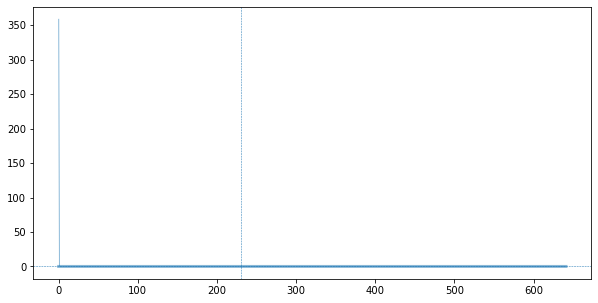

In [59]:
nets = [
    (search.best_estimator_,'ec-best_oldarch'),
    (net_regr_man, 'manual cvp?')
]

sk_loss_plot(nets)

YTRUE torch.Size([1362, 92])
**** ave r2:     -0.0005887257365900982
**** r2 overall: -0.0005887258745234803
YTRUE torch.Size([341, 92])
**** ave r2:     -0.0030626685740936716
**** r2 overall: -0.003062669608321528


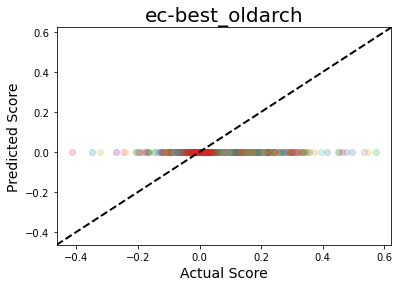

NotInitializedError: This NeuralNetRegressor instance is not initialized yet. Call 'initialize' or 'fit' with appropriate arguments before using this method.

In [60]:
view_preds(nets,make_legend=False)

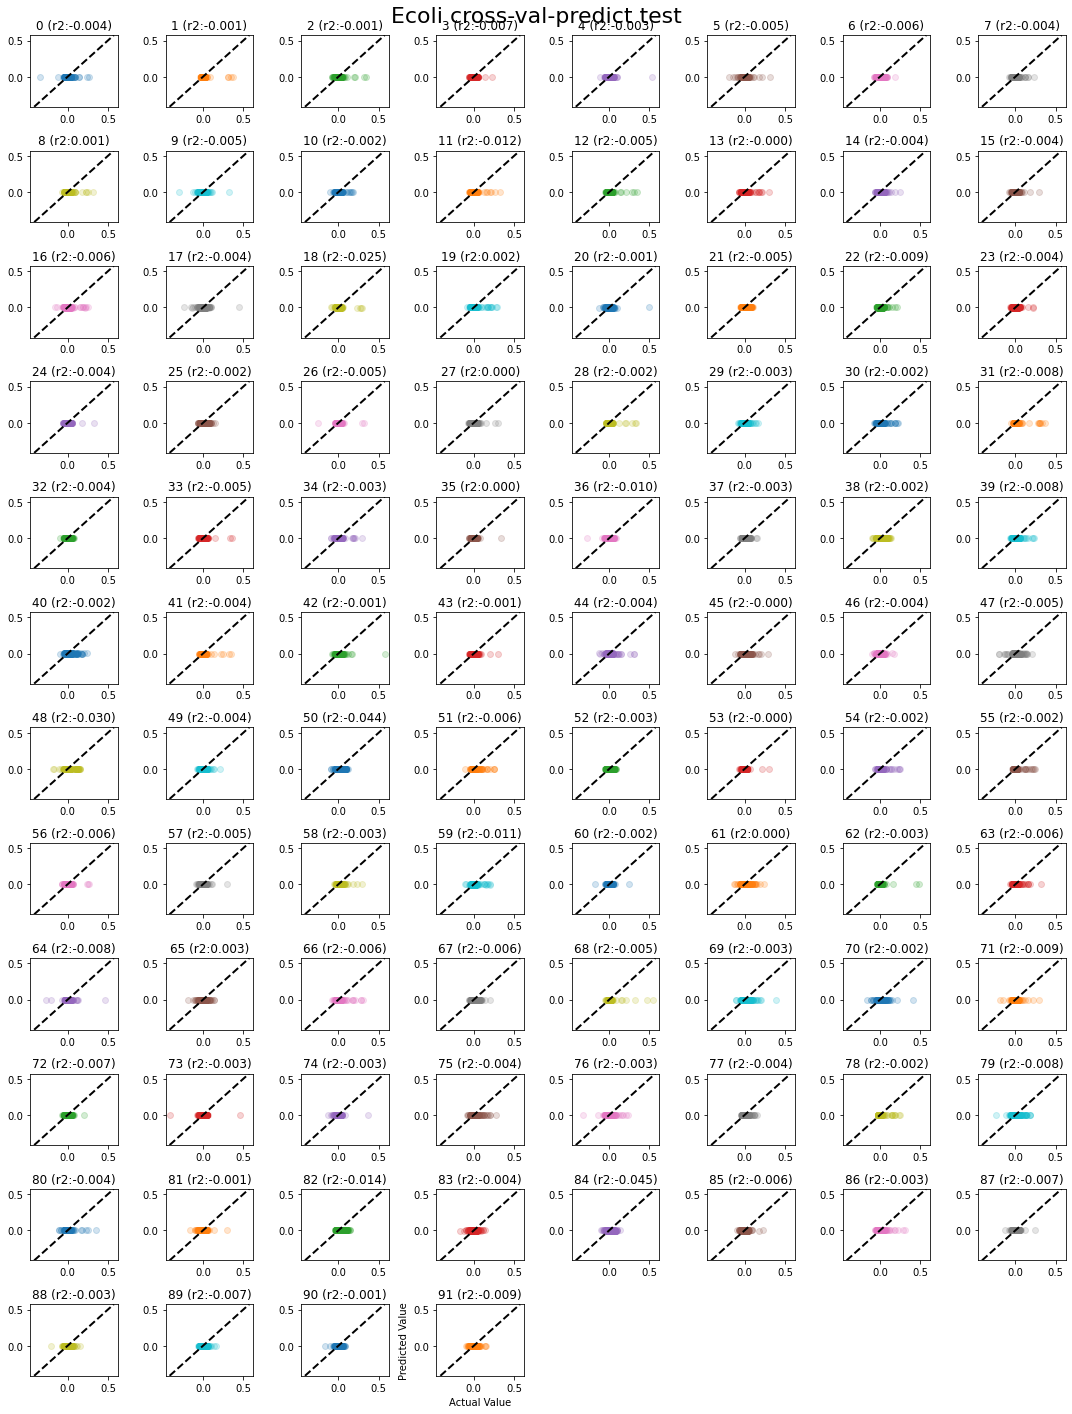

In [61]:
view_multi_parity("Ecoli cross-val-predict test", 
    y, 
    y_pred,
    rigid=True)

# Next ideas
* Retry with data aug 
* gradient clipping


# NOTE: 
--> using "load_best" = True seems to work now?? Stops on the final one